In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn
from PIL import Image
import os
from sklearn.utils import shuffle

input_shape = (200,200,3)
base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [2]:
pip install staintools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14072 sha256=c6880a4b43b730a18251d8d2f8b7444fe1232751eff5b6fd0c01a2b55e8601bc
  Stored in directory: /root/.cache/pip/wheels/09/ed/d3/94d11aa73ab04cc3a727faa6ee8618ff540877cb98a7abb14e
Successfully built staintools


In [3]:
pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp38-cp38-linux_x86_64.whl size=3241032 sha256=b793b63df90b2cbad3c6fba3e1ccdbee80a817a462514122f70213f41011b71f
  Stored in directory: /root/.cache/pip/wheels/38/d6/cd/b79299cdb26aa57760dbbeb096bc8b71b10c69f4bb95dbd16c
Successfully built spams


In [5]:
# freeze the convolutional layers of base model
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
fc_layer = tf.keras.layers.Dense(3, activation='softmax')

# build model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = fc_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
# load data
ds = np.load('Aperio_dataset_all_large.npy', allow_pickle=True)

frames_train, labels_train = ds.item().get('train')[0], ds.item().get('train')[1] - 1
frames_val, labels_val = ds.item().get('val')[0], ds.item().get('val')[1] - 1
frames_test, labels_test = ds.item().get('test')[0], ds.item().get('test')[1] - 1

print("Train set: ", frames_train.shape,labels_train.shape)
print("Validation set: ", frames_val.shape,labels_val.shape)
print("Test set: ", frames_test.shape,labels_test.shape)

Train set:  (165, 458, 513, 3) (165,)
Validation set:  (42, 458, 513, 3) (42,)
Test set:  (90, 458, 513, 3) (90,)


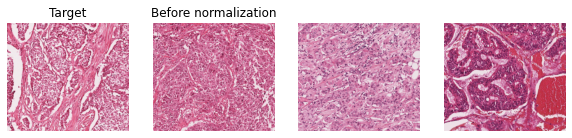

In [ ]:
# before normalization
plt.figure(figsize=(10, 10))
for i in range(4):
  plt.subplot(1,4, i+1)
  plt.imshow(frames_train[i])
  if i == 0:
    plt.title("Target")
  if i == 1:
    plt.title("Before normalization")
  plt.axis('off')
plt.show()

In [7]:
# stain normalization

import staintools

target = frames_train[0]
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(np.uint8(255*target))

def stain_normalization(images,normalizer):
    transformed = np.zeros(images.shape)
    for i in range(images.shape[0]):
      transformed[i] = normalizer.transform(images[i])
    return transformed

frames_train = stain_normalization(np.uint8(255*frames_train), normalizer) / 255
frames_val = stain_normalization(np.uint8(255*frames_val), normalizer) / 255
frames_test = stain_normalization(np.uint8(255*frames_test), normalizer) / 255

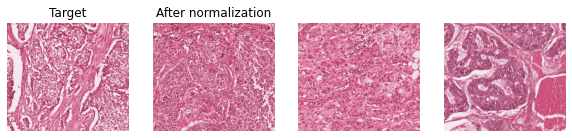

In [8]:
# after normalization
plt.figure(figsize=(10, 10))
for i in range(4):
  plt.subplot(1,4, i+1)
  plt.imshow(frames_train[i])
  if i == 0:
    plt.title("Target")
  if i == 1:
    plt.title("After normalization")
  plt.axis('off')
plt.show()

In [9]:
# divide images to patches

patch_size = 200
stride = 100
nof_patches = 12

# train
patches_train = tf.image.extract_patches(images=frames_train,
                           sizes=[1, patch_size, patch_size, 1],
                           strides=[1, stride, stride, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

imgs = patches_train.shape[0]*nof_patches
patches_train = tf.reshape(patches_train,shape=(imgs,patch_size,patch_size,3))
patch_labels_train = np.repeat(labels_train, nof_patches)

print('Train:')
print(patches_train.shape)
print(patch_labels_train.shape)

# validation
patches_val = tf.image.extract_patches(images=frames_val,
                           sizes=[1, patch_size, patch_size, 1],
                           strides=[1, stride, stride, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

imgs = patches_val.shape[0]*nof_patches
patches_val = tf.reshape(patches_val,shape=(imgs,patch_size,patch_size,3))
patch_labels_val = np.repeat(labels_val, nof_patches)

print('Validation')
print(patches_val.shape)
print(patch_labels_val.shape)

# test
patches_test = tf.image.extract_patches(images=frames_test,
                           sizes=[1, patch_size, patch_size, 1],
                           strides=[1, stride, stride, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

imgs = patches_test.shape[0]*nof_patches
patches_test = tf.reshape(patches_test,shape=(imgs,patch_size,patch_size,3))
patch_labels_test = np.repeat(labels_test, nof_patches)

print('Test')
print(patches_test.shape)
print(patch_labels_test.shape)

Train:
(1980, 200, 200, 3)
(1980,)
Validation
(504, 200, 200, 3)
(504,)
Test
(1080, 200, 200, 3)
(1080,)


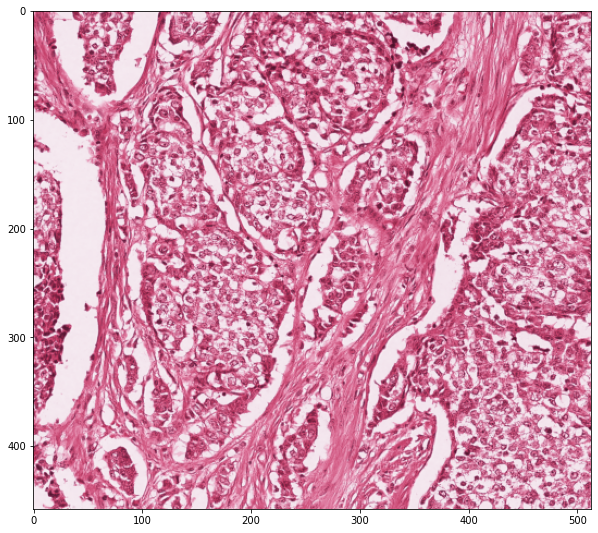

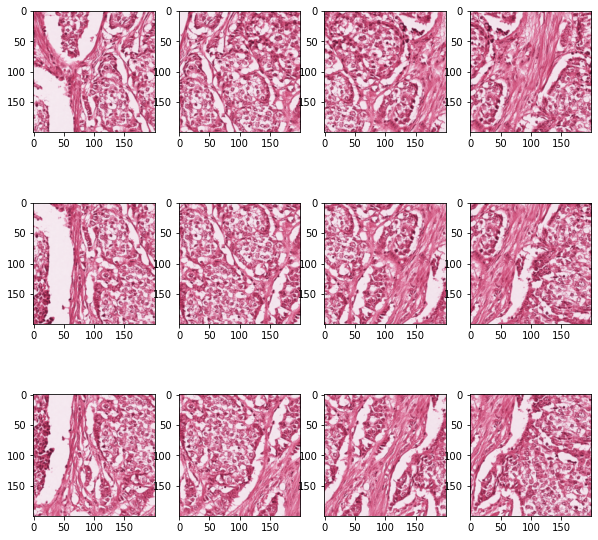

In [10]:
# show patches
plt.figure(figsize=(10, 10))
plt.imshow(frames_train[1])

plt.figure(figsize=(10, 10))
count = 0
for i in range(nof_patches,2*nof_patches):
    ax = plt.subplot(3, 4, count+1)
    plt.imshow(patches_train[i])
    #plt.axis('off')
    count += 1
plt.show()

In [12]:
from sklearn.utils import class_weight

# shuffle validation data
np.random.seed(42)
shuffled_indices = np.random.permutation(patches_val.shape[0])
shuffled_patches_val = tf.gather(patches_val, shuffled_indices, axis=0)
shuffled_patch_labels_val = tf.gather(patch_labels_val, shuffled_indices)

# calculate class weights
class_weight = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)
class_weight = dict(zip(np.unique(labels_train), class_weight))

history = model.fit(patches_train, patch_labels_train, epochs=10, validation_data=(shuffled_patches_val,shuffled_patch_labels_val), shuffle=True, class_weight=class_weight)

Epoch 1/10
62/62 [==============================] - 183s 3s/step - loss: 1.0702 - sparse_categorical_accuracy: 0.4187 - val_loss: 0.8960 - val_sparse_categorical_accuracy: 0.5476
Epoch 2/10
62/62 [==============================] - 173s 3s/step - loss: 0.7476 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.8245 - val_sparse_categorical_accuracy: 0.5774
Epoch 3/10
62/62 [==============================] - 175s 3s/step - loss: 0.6335 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.5853
Epoch 4/10
62/62 [==============================] - 174s 3s/step - loss: 0.5658 - sparse_categorical_accuracy: 0.6727 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.6190
Epoch 5/10
62/62 [==============================] - 172s 3s/step - loss: 0.5136 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.8051 - val_sparse_categorical_accuracy: 0.6111
Epoch 6/10
62/62 [==============================] - 177s 3s/step - loss: 0.4839 - sparse_categorical_accu

In [14]:
eval = model.evaluate(patches_test, patch_labels_test)

34/34 [==============================] - 78s 2s/step - loss: 0.9124 - sparse_categorical_accuracy: 0.6102


In [15]:
y_score = model.predict(patches_test)
y_pred = np.argmax(y_score, axis=1)

34/34 [==============================] - 77s 2s/step


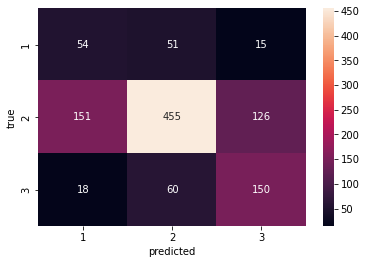

In [17]:
# plot patch-wise confusion matrix

import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(patch_labels_test,y_pred)
ax = sn.heatmap(cm, annot=True, fmt=".0f", xticklabels=("1","2","3"), yticklabels=("1","2","3"))
ax.set(xlabel="predicted", ylabel="true")
plt.show()

In [18]:
# image-wise predictions

from sklearn.metrics import accuracy_score
from scipy.stats import mode
start = 0
end = nof_patches
n = int(len(patch_labels_test)/nof_patches)
y_pred_images = np.zeros(n)
for i in range(0,n):
  mode1, counts1 = mode(y_pred[start:end])
  y_pred_images[i] = mode1
  start += nof_patches
  end += nof_patches

print("Image-wise test accuracy: ", accuracy_score(labels_test, y_pred_images))

Image-wise test accuracy:  0.7222222222222222


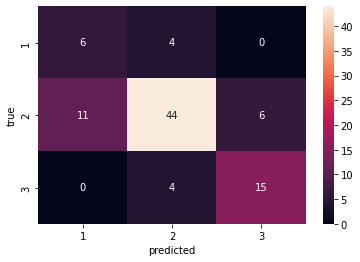

In [19]:
# plot image-wise confusion matrix
cm2 = confusion_matrix(labels_test,y_pred_images)
ax = sn.heatmap(cm2, annot=True, xticklabels=("1","2","3"), yticklabels=("1","2","3"))
ax.set(xlabel="predicted", ylabel="true")
plt.show()

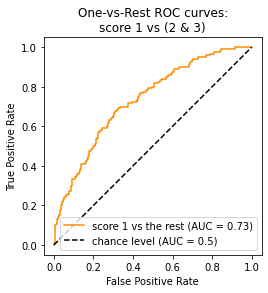

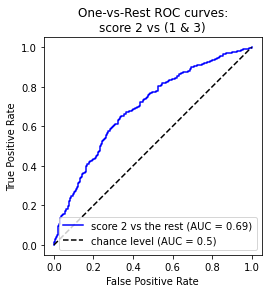

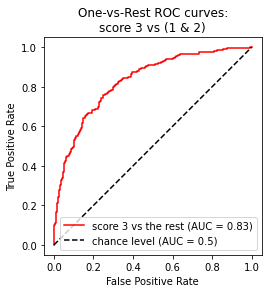

In [21]:
# ROC-curves
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(patch_labels_train)
y_onehot_test = label_binarizer.transform(patch_labels_test)

class_id = 0
class_of_interest = "score 1"
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nscore 1 vs (2 & 3)")
plt.legend()

class_id = 1
class_of_interest = "score 2"
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="blue",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nscore 2 vs (1 & 3)")
plt.legend()

class_id = 2
class_of_interest = "score 3"
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="red",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nscore 3 vs (1 & 2)")
plt.legend()
plt.show()

In [28]:
# calculate other evaluation metrics: precision, specificity, f-score and accuracy for each class
from sklearn.metrics import classification_report

target_names = ['Score 1', 'Score 2', 'Score 3']
print(classification_report(labels_test, y_pred_images, target_names=target_names))

def specificity(cm,cl):
  if cl == 0:
    tn = cm[cl+1][cl+1] + cm[cl+2][cl+2]
    fp = cm[cl+1][cl] + cm[cl+2][cl]
    return tn/(tn+fp)
  elif cl == 1:
    tn = cm[cl-1][cl-1] + cm[cl+1][cl+1]
    fp = cm[cl-1][cl] + cm[cl+1][cl]
  elif cl == 2:
    tn = cm[cl-2][cl-2] + cm[cl-1][cl-1]
    fp = cm[cl-2][cl] + cm[cl-1][cl]
  return tn/(tn+fp)

print("Specificity")
print("Score 1: ", specificity(cm2,0))
print("Score 2: ", specificity(cm2,1))
print("Score 3: ", specificity(cm2,2))

              precision    recall  f1-score   support

     Score 1       0.35      0.60      0.44        10
     Score 2       0.85      0.72      0.78        61
     Score 3       0.71      0.79      0.75        19

    accuracy                           0.72        90
   macro avg       0.64      0.70      0.66        90
weighted avg       0.76      0.72      0.74        90

Specificity
Score 1:  0.8428571428571429
Score 2:  0.7241379310344828
Score 3:  0.8928571428571429
